<a href="https://colab.research.google.com/github/a-0yahya/Portfolio_A.Y/blob/main/RoBERTa_ABSA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
from transformers import RobertaTokenizer, RobertaModel, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns
import time
import json

In [4]:
# Load and Preprocess the Dataset
df = pd.read_csv("dataset.csv")  # Update with your file path if needed
df.rename(columns={"Reviews": "sentence"}, inplace=True)

# Use the 'sentiment' column as overall sentiment
df["overall_sentiment"] = df["sentiment"]

# Split Data: 80% Train, 10% Validation, 10% Test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")


Train samples: 1543, Val samples: 193, Test samples: 193


In [5]:
df.head()

,sentence,sentiment,overall_sentiment
0,foto jaman disik kamerane elek ddine meninggal...,0,0
1,happy wedding brother sory kamerane elek with ...,0,0
2,maaf gak saingan sek ig storymu kamerane elek,0,0
3,gasempet foto soale kamerane elek koyo kowe,0,0
4,endak mas ikuw saking kamerane elek lek hujan ...,0,0


In [25]:
# Define Custom Dataset Class for Sentiment Analysis
class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.sentences = dataframe["sentence"].tolist()
        self.sentiments = dataframe["overall_sentiment"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = str(self.sentences[index])
        encoding = self.tokenizer(
            sentence,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.sentiments[index], dtype=torch.long)
        }

        return item


In [26]:
# Define the RoBERTa Model for Sentiment Analysis
class RobertaForSentiment(nn.Module):
    def __init__(self, num_sentiments):
        super(RobertaForSentiment, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.sentiment_classifier = nn.Linear(self.roberta.config.hidden_size, num_sentiments)
        self.dropout = nn.Dropout(0.3)  # Adding dropout layer for regularization

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)  # Apply dropout
        sentiment_logits = self.sentiment_classifier(pooled_output)
        return sentiment_logits

# Setup model, optimizer, and loss functions
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
num_sentiments = len(df["overall_sentiment"].unique())
model = RobertaForSentiment(num_sentiments=num_sentiments)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

sentiment_loss_fn = nn.CrossEntropyLoss()
learning_rate = 5e-6  # Experiment with this learning rate for stability
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)  # Increased weight decay for regularization

# Define DataLoader for batching
train_dataset = SentimentDataset(train_df, tokenizer)
val_dataset = SentimentDataset(val_df, tokenizer)
test_dataset = SentimentDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
# Define the evaluation function
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    total_samples = 0
    correct_preds = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            sentiment_logits = model(input_ids, attention_mask)
            loss = sentiment_loss_fn(sentiment_logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(sentiment_logits, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = correct_preds / total_samples
    avg_loss = total_loss / len(dataloader)

    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return accuracy, precision, recall, f1, all_labels, all_preds, avg_loss

In [28]:
print(df["overall_sentiment"].unique())  # Check the unique sentiment labels again


[0 1 2]


In [10]:
pip install ace_tools

In [11]:
import torch
from sklearn.metrics import classification_report
import pandas as pd
from torch.utils.data import DataLoader


1	1.067021	0.935505	0.497409	0.529028	0.515651	0.482312
2	0.878026	0.755657	0.668394	0.669158	0.659397	0.653151
3	0.694850	0.670725	0.746114	0.754320	0.733244	0.739998
4	0.514060	0.551903	0.797927	0.802608	0.792181	0.796335
5	0.393897	0.471067	0.803109	0.802468	0.799359	0.799882
6	0.305231	0.483217	0.844560	0.846496	0.842831	0.844345
7	0.236804	0.512549	0.886010	0.893494	0.880385	0.885463
8	0.184927	0.433622	0.875648	0.875427	0.876646	0.875915
9	0.139600	0.495079	0.880829	0.886395	0.875094	0.879596
10	0.113343	0.415194	0.875648	0.880081	0.872725	0.875825
11	0.089939	0.614314	0.849741	0.848385	0.855999	0.849763
12	0.073454	0.456639	0.875648	0.889343	0.872689	0.878547
13	0.051367	0.430176	0.896373	0.902714	0.895850	0.897906
14	0.040253	0.417832	0.875648	0.884829	0.874686	0.878836
Early stopping triggered at Epoch 14.

Training Results Summary:
    Epoch  Training Loss  Validation Loss  Accuracy  Precision    Recall  \
0       1       1.067021         0.935505  0.497409   0.529028  0.5156

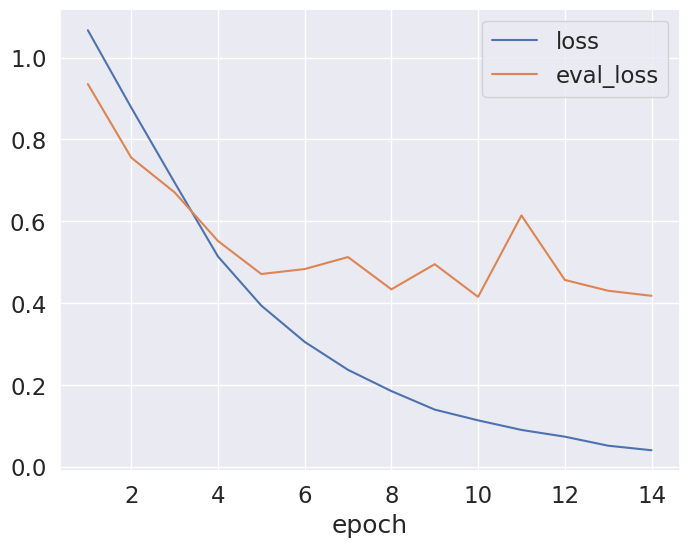

Test Accuracy: 0.8549, Test F1: 0.8602, Test Recall: 0.8567, Test Precision: 0.8545


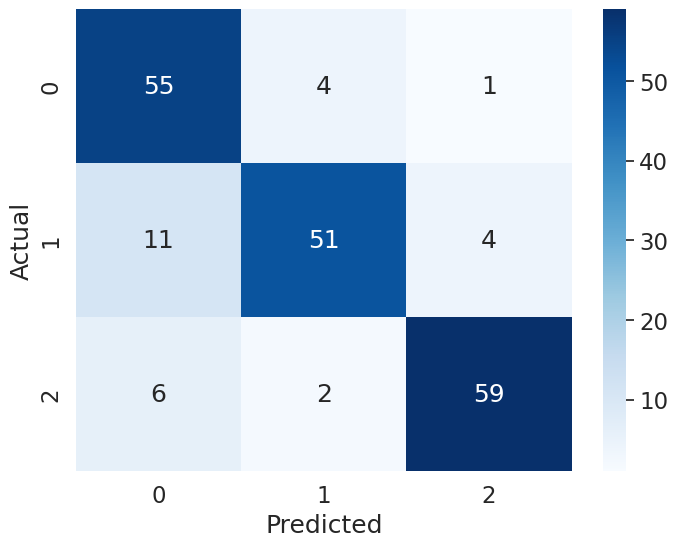

In [29]:
# Training Loop with Early Stopping
num_epochs = 100
patience = 4
best_val_loss = float("inf")
patience_counter = 0

train_losses = []
val_losses = []
results = []
best_f1_score = 0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_samples = 0
    correct_train_preds = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        sentiment_logits = model(input_ids, attention_mask)
        loss = sentiment_loss_fn(sentiment_logits, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = torch.argmax(sentiment_logits, dim=1)
        correct_train_preds += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    train_accuracy = correct_train_preds / total_train_samples
    train_loss = total_train_loss / len(train_loader)

    val_acc, val_precision, val_recall, val_f1, val_labels, val_preds, val_loss = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    results.append([epoch + 1, train_loss, val_loss, val_acc, val_precision, val_recall, val_f1])

    print(f"{epoch+1}\t{train_loss:.6f}\t{val_loss:.6f}\t{val_acc:.6f}\t{val_precision:.6f}\t{val_recall:.6f}\t{val_f1:.6f}")

    if val_f1 > best_f1_score:
        best_f1_score = val_f1
        best_epoch = epoch + 1

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at Epoch {epoch + 1}.")
        break

# Display results
results_df = pd.DataFrame(results, columns=["Epoch", "Training Loss", "Validation Loss", "Accuracy", "Precision", "Recall", "F1"])
print("\nTraining Results Summary:")
print(results_df)

print(f"Best F1 score: {best_f1_score:.6f} at Epoch {best_epoch}")

# Plotting the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="eval_loss")
plt.xlabel('epoch')
plt.legend()
plt.show()

# Confusion Matrix Generation for Test Set
test_acc, test_f1, test_recall, test_precision, test_labels, test_preds, _ = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}, Test Recall: {test_recall:.4f}, Test Precision: {test_precision:.4f}")

generate_confusion_matrix(test_labels, test_preds, num_sentiments)

In [24]:
# Example usage for a single text
sample_text = "the phone battery amazing."
max_length = 128  # Define the max_length here or earlier in your code
encoding = tokenizer(sample_text, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").to(device)
with torch.no_grad():
    sentiment_logits = model(encoding["input_ids"], encoding["attention_mask"])
sentiment_pred = torch.argmax(sentiment_logits, dim=1).item()
print(f"Predicted sentiment: {sentiment_pred}")

Predicted sentiment: 1
